In [43]:
from datasets import load_dataset
#access locaclly stored dataset in this path testing_for_error/asking_armor_data.json and is a json file

train_dataset = load_dataset("json", data_files="dataset_final_results/final_train.json", field="data")

In [44]:
train_dataset

DatasetDict({
    train: Dataset({
        features: ['Speaker', 'Event', 'Dialogue', 'Line_of_dialogue', 'Response_to', 'Race', 'Game', 'Equipment', 'Monologue', 'Condition', 'Result', 'Context', 'Location', 'Tone'],
        num_rows: 1456
    })
})

In [33]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [53]:
def formatting_func(example):
    
    if 'Monologue' in example and example['Monologue'] is not None:
        return f"""
In the following text, there is a description of the introductory monologue in video games. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the title of the current game will always be enclosed inside " ", the monologue will always be enclosed inside $ $, and the context will be enclosed inside # #.
         
<START>
In video games, sometimes there is an introductory monologue delivered by a Speaker. The Speaker can either be an unknown narrator or a character in the game, and they introduce the Player to the world, the story, and the setting of the game. For the game "{example['Game']}", the introductory monologue is as follows:

${example['Monologue']}$

This monologue is based on the game's setting, world, story, and the Player's role in the game. Here is some context describing these elements:

#{example['Context']}#
<END>"""
    
    
    
    description = f"""The following text describes a line of dialogue used by an NPC in a certain event. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed inside & &, the speaker will be enclosed inside % %, the line spoken will be enclosed inside " ".

"""
    if example['Event'] == "Greeting":
        
        description = f"""The following text describes a greeting exchange between the Player and an NPC based on an event. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed inside & &, the type of speaker will be enclosed inside % %, the line spoken will be enclosed inside " ", and the tone of the line will be enclosed inside ; ;.

"""
    elif example['Event'] == "NPCs fighting over a Player's dropped item":
        
        description = f"""The following text describes an exchange where multiple NPCs are fighting over a Player's dropped item and one of them uses a line of dialogue. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed inside & &, the number of the current spoken line in the dialogue will be enclosed inside ~ ~, the line spoken will be enclosed inside " ", and the speaker will be enclosed inside % %.

"""
    elif 'Condition' in example and example['Condition'] == "in combat":
        
        description = f"""The following text states which line of dialogue a friendly NPC uses when it is in combat. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed inside & &, the condition will be enclosed inside ( ), the line spoken will be enclosed inside " ", and the speaker will be enclosed inside % %.

"""
    elif 'Result' in example and example['Result'] is not None:
        
        description = f"""The following text states which line of dialogue is used by an NPC when the Player character tries to persuade them. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed inside & &, the line spoken will be enclosed inside " ", the result of the event will be enclosed inside @ @ and the speaker enclosed inside % %.

"""
    elif 'Race' in example and example['Race'] is not None:
        
        description = f"""The following text describes the reaction of a Guard based on the Player's race. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed inside & &, the speaker will be enclosed inside % %, the line spoken will be enclosed inside " ", the race of the Player will be enclosed inside * *, and the condition , if there is one, will be enclosed inside ( ).

"""
    elif 'Equipment' in example and example['Equipment'] is not None:
        
        description = f"""The following text describes the reaction of a Guard based on the Player's equipment. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed inside & &, the speaker will be enclosed inside % %, the line spoken will be enclosed inside " ", the equipment of the Player will be enclosed inside [ ], and the condition , if there is one, will be enclosed inside ( ).

"""
    elif 'Location' in example and example['Location'] is not None:
        
        description = f"""The following text describes a special interaction of a Guard based on the Player's location. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed inside & &, the speaker will be enclosed inside % %, the line spoken will be enclosed inside " ", the location of the Player will be enclosed inside ^ ^, and the condition , if there is one, will be enclosed inside ( ).

"""
        
    elif 'Response_to' in example and example['Response_to'] is not None:
        
        description = f"""The following text describes a part of a dialogue between and NPC and the Player in the case of a certain event. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed inside & &, the speaker will be enclosed inside % %, the line spoken will be enclosed inside " ", and the line that the speaker responds to, will be enclosed inside | |.

"""
    elif 'Condition' in example and example['Condition'] != "nan":
        
        description = f"""The following text describes a line of dialogue used by an NPC in a certain event under a condition. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed inside & &, the speaker will be enclosed inside % %, the line spoken will be enclosed inside " ", and the condition, will be enclosed inside ( ).

"""
    
    
    if example['Speaker'] == "Any":
        
        npc_type = "the NPC, that is of any type"
        
    elif "Guard" in example['Speaker']:
        
        npc_type = f'the {example["Speaker"]}'
        
    elif "trainer" in example['Event']:
        
        npc_type = f'the trainer NPC, that is named {example['Speaker']}'
        
    elif example['Speaker'] == "Housecarl":
        
        npc_type = "the Housecarl"

    else:
        
        npc_type = f'the NPC, that is the type {example["Speaker"]}'
    
    
    
    if example['Event'] == "Greeting":
        
        return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, in the case of a &{example['Event']}&, between an NPC and the Player character, %{npc_type}% greets the Player with the following dialogue: {example['Dialogue']}, in a ;{example['Tone']}; tone.
<END>"""
    
    
    if example['Event'] == "Goodbye":
        
        return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, in the case of a &{example['Event']}&, between an NPC and the Player character,%{npc_type}% tells their goodbyes to the Player with the following dialogue: {example['Dialogue']}.
<END>"""
    
    
    if example['Event'] == "NPCs fighting over a Player's dropped item":
        
        return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, in the event of &{example['Event']}&, there can be up to 5 different NPCs arguing over an item that the Player character dropped and up to 2 bystander NPCs commenting on the situation. Up to five lines of dialogue can be exchanged between up to five different NPCs that are arguing and up to two lines of bystander dialogue can be used by up to two different bystander NPCs, meaning that the conversation ends after a maximum of 7 lines of dialogue have been said. In this case one of the NPCs that takes part in the arguing and %{npc_type}%, says the following line: {example['Dialogue']}, as the ~{example['Line_of_dialogue']}~ line of the dialogue.
<END>"""
    
    if example['Event'] == "NPC asking for the Player's dropped armor":

        if example['Speaker'] == "Player":
            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, in the event of an &{example['Event']}&, there is a conversation between the Player character and an NPC about the Player's dropped item. 
In this case the %Player% character says the following line: {example['Dialogue']}, in response to the NPC's previous line of dialogue: |{example['Response_to']}|.
<END>"""
        
        if example['Response_to'] != "nan":

            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, in the event of an &{example['Event']}& there is a conversation between the Player character and an NPC about the Player's dropped item. 
In this case %{npc_type}%, says the following line: {example['Dialogue']}, in response to the Player character's previous line of dialogue: |{example['Response_to']}|.
<END>"""
        else:

            return description + f"""<<START>>
In the world of Skyrim from the game Elder Scrolls V, in the event of an &{example['Event']}& there is a conversation between the Player character and an NPC about the Player's dropped item. 
In this case %{npc_type}%, says the following line: {example['Dialogue']}, to initiate a conversation about the Player's dropped item.
<END>"""
    
    if 'Condition' in example and example['Condition'] == "in combat":
        
        return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, when the Player character and a friendly NPC are ({example['Condition']}), %{npc_type}%, uses this line of dialogue: {example['Dialogue']}, when it is &{example['Event']}&.
<END>"""
        
    if 'Result' in example:
        
            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, when the Player character tries to check if an NPC of any type can be persuaded, the %{npc_type}%, uses the following line of dialogue: {example['Dialogue']}, when &{example['Event']}& and as a result @{example['Result']}@.
<END>"""
    
    if example['Event'] == "an NPC spots the Player character having an amulet of mara":
        
        if example['Speaker'] == "Player":
            
            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, when &{example['Event']}& an interaction begins between the two about the possibility of marriage. 
In this case the %Player% character, says the following line: {example['Dialogue']}, as a response to the the NPC's dialogue line: |{example['Response_to']}|.
<END>"""
        
        if example['Response_to'] == "nan":
            
            return description +  f"""<START>
In the world of Skyrim from the game Elder Scrolls V, when &{example['Event']}& an interaction begins between the two about the possibility of marriage.
In this case %{npc_type}%, says the following line: {example['Dialogue']}, to initiate the conversation about marriage.
<END>"""
        
        else:
            
            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, when &{example['Event']}& an interaction begins between the two about the possibility of marriage. 
In this case %{npc_type}%, says the following line: {example['Dialogue']}, as a response to the the Player's dialogue line: |{example['Response_to']}|.
<END>"""
    
    if 'Race' in example:
        
        if example['Condition'] != "nan":
            
            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, Town Guards have special reactions to the race of the Player character, so in the case of &{example['Event']}& if the Player's race is *{example['Race']}*, the %Guard% reacts with this line of dialogue: {example['Dialogue']}, on the condition that the ({example['Condition']}).
<END>"""
        
        else:
            
            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, Town Guards have special reactions to the race of the Player character, so in the case of &{example['Event']}& if the Player's race is *{example['Race']}*, the %Guard% reacts with this line of dialogue: {example['Dialogue']}.
<END>"""
     
    if 'Equipment' in example:
        
        if example['Condition'] != "nan":
            
            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, Town Guards have special reactions to the equipment the Player is holding or has equipped, so when in the case of a &{example['Event']}&, the %Guard% uses this line of dialogue: {example['Dialogue']}, to react to the Player's [{example['Equipment']}], on the condition that ({example['Condition']}).
<END>"""
        
        else: 
            
            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, Town Guards have special reactions to the equipment the Player is holding or has equipped, so when in the case of a &{example['Event']}&, the %Guard% uses this line of dialogue: {example['Dialogue']}, to react to the Player's [{example['Equipment']}].
<END>"""
            
    if 'Location' in example:
        
        if example['Condition'] != "nan":
            
            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, &Town Guards have special interactions with the Player character that are location based&, meaning that the Guards sometimes interact with the Player using town specific dialogue.
In this case a %Guard% in the town of ^{example['Location']}^ might use this line of dialogue: {example['Dialogue']}, when the Player interacts with them, on the condition that ({example['Condition']}).
<END>"""
        
        else: 
            
            return description + f"""<START>
rtebgIn the world of Skyrim from the game Elder Scrolls V, &Town Guards have special interactions with the Player character that are location based&, meaning that the Guards sometimes interact with the Player using town specific dialogue.
In this case a %Guard% in the town of ^{example['Location']}^ might use this line of dialogue {example['Dialogue']}, when the Player interacts with them.
<END>"""
        
    if 'Condition' in example:
        
        if example['Condition'] != "nan":
            
            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, in the event of &{example['Event']}&, %{npc_type}%, says the following line to the Player character: {example['Dialogue']}, on the condition that ({example['Condition']}).
<END>"""
    
    return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, in the event of &{example['Event']}&, %{npc_type}%, says the following line to the Player character: {example['Dialogue']}.
<END>"""

In [6]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-Instruct-v0.2"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)

tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token


`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [54]:
def generate_and_tokenize_prompt(prompt):
    print(formatting_func(prompt))
    return tokenizer(formatting_func(prompt))

In [55]:
print(formatting_func(train_dataset['train'][1]))

The following text describes a part of a dialogue between and NPC and the Player in the case of a certain event. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed inside & &, the speaker will be enclosed inside % %, the line spoken will be enclosed inside " ", and the line that the speaker responds to, will be enclosed inside | |.

<START>
In the world of Skyrim from the game Elder Scrolls V, when the Player character tries to check if an NPC of any type can be persuaded, the %the NPC, that is the type FemaleArgonian%, uses the following line of dialogue: "Very well. I am poorer for it.", when &an NPC spots the Player character having an amulet of mara& and as a result @None@.
<END>


In [26]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)

In [28]:
print(tokenized_train_dataset['train'][1])

{'Speaker': 'MaleSlyCynical', 'Event': "NPCs fighting over a Player's dropped item", 'Line_of_dialogue': '3rd', 'Dialogue': '"I think not."', 'Response_to': None, 'Race': None, 'Game': None, 'Equipment': None, 'Monologue': None, 'Condition': None, 'Result': None, 'Context': None, 'Location': None, 'Tone': None, 'input_ids': [1, 28705, 13, 657, 272, 2296, 2245, 28725, 736, 349, 264, 5436, 302, 272, 24671, 2478, 695, 1326, 1165, 441, 297, 3798, 3897, 28723, 415, 2245, 622, 347, 481, 12848, 2373, 523, 12241, 28767, 304, 523, 5000, 13902, 1387, 460, 2948, 5879, 369, 5580, 865, 298, 272, 2245, 28747, 272, 3941, 302, 272, 1868, 2039, 622, 1743, 347, 481, 12848, 3416, 345, 7717, 272, 1326, 1165, 441, 622, 1743, 347, 481, 12848, 3416, 429, 28542, 304, 272, 2758, 622, 347, 481, 12848, 3416, 422, 422, 28723, 13, 2600, 13, 28789, 12241, 28767, 13, 657, 3798, 3897, 28725, 4662, 736, 349, 396, 24671, 2478, 695, 1326, 1165, 441, 11448, 486, 264, 8819, 4776, 28723, 415, 8819, 4776, 541, 2477, 347, 39

1637


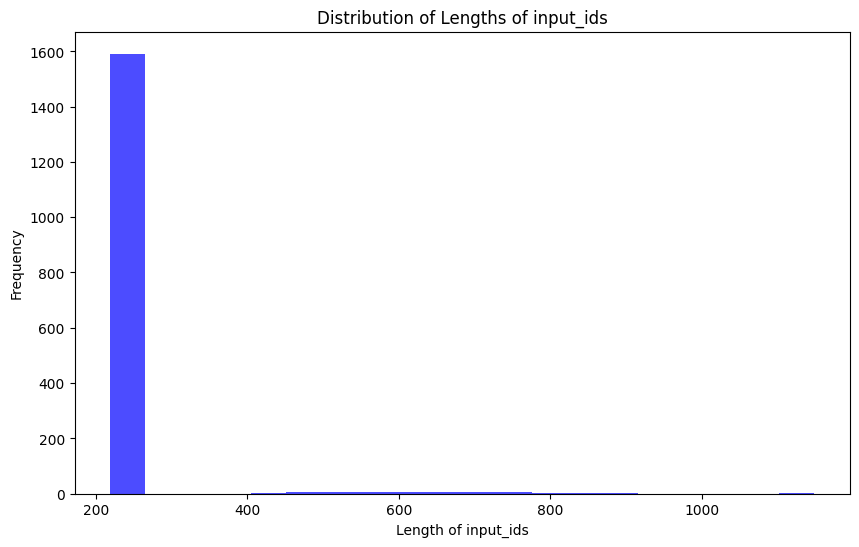

In [12]:
import matplotlib.pyplot as plt


def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset['train']]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset['train']]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()


plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [ ]:
max_length = 120  # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

In [ ]:
print(tokenized_train_dataset['train'][1]['input_ids'])

In [ ]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [ ]:
eval_prompt = ("")

In [ ]:
# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0],
                                skip_special_tokens=True))

In [ ]:
from peft import PeftConfig

adapter_model_id = "ybelkada/opt-350m-lora"
peft_config = PeftConfig.from_pretrained(adapter_model_id)
# to initiate with random weights
peft_config.init_lora_weights = False

model.add_adapter(peft_config)
model.enable_adapters()

In [ ]:
print("###Character: " + test_dataset['train'][200]['character'] + "\n  responded with: " + test_dataset['train'][200][
    'dialogue'] + "\n to what was said by: " + test_dataset['train'][200]['response_to'])

In [ ]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

In [ ]:
print(model)

In [ ]:
if torch.cuda.device_count() > 1:  # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [ ]:
model = accelerator.prepare_model(model)

In [ ]:
import transformers
from datetime import datetime

project = "own-finetune"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset["train"],
    eval_dataset=tokenized_val_dataset["train"],
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=200,
        learning_rate=2.5e-5,  # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,  # When to start reporting loss
        logging_dir="./logs",  # Directory for storing logs
        save_strategy="steps",  # Save the model checkpoint every logging step
        save_steps=25,  # Save checkpoints every 50 steps
        evaluation_strategy="steps",  # Evaluate the model every logging step
        eval_steps=25,  # Evaluate and save checkpoints every 50 steps
        do_eval=True,
        # Perform evaluation at the end of training         # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"  # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-Instruct-v0.2"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

In [ ]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "mistral-own-finetune/checkpoint-50")

In [ ]:
eval_prompt = "Start a conversation where Dutch van der Linde plans a new heist"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=280, repetition_penalty=1.15)[0],
                                skip_special_tokens=True))

# Rouge Score

In [ ]:
generated_dialogues = ["Doctor:  I'm afraid you have tuberculosis. We need to start treatment right away.",
                       "Arthur Morgan: Tuberculosis... That's a death sentence isn't it?"]

reference_dialogues = ["Doctor: You got tuberculosis. I’m really sorry for you, son, it’s a hell of a thing.",
                       "Arthur Morgan: Aah… What is it?"]

print(len(reference_dialogues))

from rouge import Rouge

rouge = Rouge()
rouge_scores = rouge.get_scores(' '.join(generated_dialogues), ' '.join(reference_dialogues[0]))

# Output the scores 

print(f"ROUGE: {rouge_scores}")


In [ ]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

# Tokenize the reference and generated dialogues into words
reference_dialogues = [
    ["Doctor:", "You", "got", "tuberculosis.", "I’m", "really", "sorry", "for", "you,", "son,", "it’s", "a", "hell", "of", "a", "thing."],
    ["Arthur", "Morgan:", "Aah…", "What", "is", "it?"]
]
generated_dialogues = [
    ["Doctor:", "I'm", "afraid", "you", "have", "tuberculosis.", "We", "need", "to", "start", "treatment", "right", "away."],
    ["Arthur", "Morgan:", "Tuberculosis...", "That's", "a", "death", "sentence", "isn't", "it?"]
]


# Calculate BLEU score
bleu_score = sentence_bleu(reference_dialogues, generated_dialogues)
print(f"BLEU: {bleu_score}")